In [1]:
import os
import sys

import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

get_ipython().magic(u'matplotlib inline')

sys.path.append('../3_analyze')
from containers import Dataset
from utils import export, show_side_by_side, show_features
from statistics import Statistics
from prob_opt import PredictStructs

In [2]:
data_dir = '/scratch/PI/rondror/jbelk/method/data'
glide_dir = 'docking/glide12'
ifp_dir = 'ifp/ifp2'
mcss_dir = 'mcss/mcss7'

chembl_file = 'best_affinity.txt'

stats_prots = ['SIGMA1','5HT2B','AR']#,'B1AR']
pred_prots = ['B1AR']

features = {
    'mcss':[],
    'hbond':[2,3],
    #'sb2':[1],
    #'sb':[4],
    'pipi':[6]
    #'picat':[7,8],
    #'contact':[11]
}

In [3]:
all_prots = stats_prots + pred_prots
all_data = Dataset(all_prots, data_dir, glide_dir, ifp_dir, mcss_dir)

# load in statistics ligands
ligands = {p: prot.lm.pdb for p,prot in all_data.proteins.items()}# if p in stats_prots}

all_data.load(ligands, load_fp=True, load_mcss=True)

warning, only 2 ligands found for 5HT2B
mcss


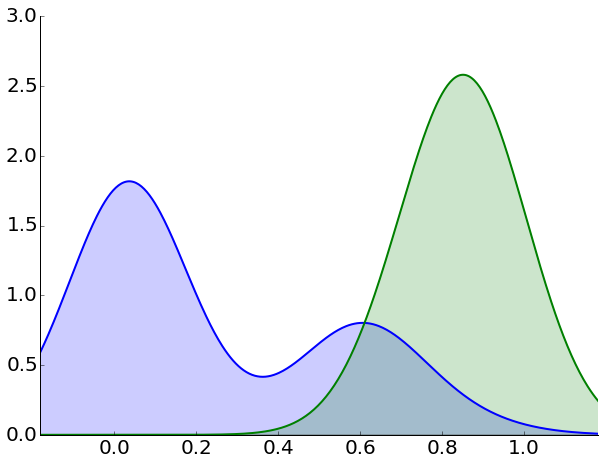

pipi


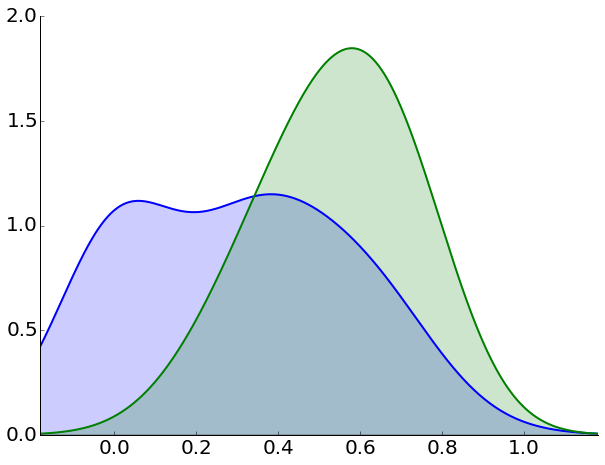

hbond


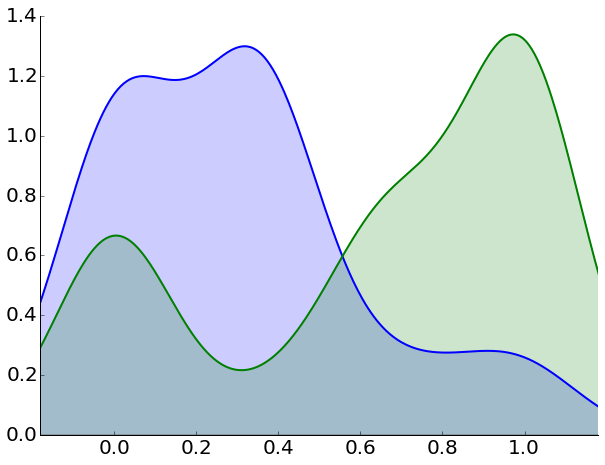

In [4]:
num_stats_ligs = 50
num_stats_poses = 100
smooth = 0.02
normalize = True
stats = Statistics(all_data, stats_prots, num_stats_ligs, num_stats_poses, features, smooth, normalize)

for f_name in features.keys():
    print f_name#, stats.evidence.std[f_name]
    stats.show_stats(f_name, raw=False, smoothed=True)
    #try:
    #    stats.show_stats_by_pair(f_name, raw=False, smoothed=True)
    #except:
    #    print 'ugh'
    #    continue

In [7]:
num_chembl = 5
num_poses = 100
t = 10

mcss_sort = 'mcss' in chembl_file

error = {}

for p in pred_prots:
    prot = all_data.proteins[p]
    ps = PredictStructs(prot.docking[prot.lm.default_st], stats.evidence, features, num_poses, t)
    
    us_rmsds = []
    glide_rmsds = []
    
    for q in prot.lm.pdb:
        print q
        
        chembl_ligs = prot.lm.get_similar(q, chembl_file, num=num_chembl, mcss_sort=mcss_sort)
        all_data.load({p:[q]+chembl_ligs})
        
        best_cluster, all_scores, all_rmsds = ps.max_posterior([q]+chembl_ligs, verbose=True, restart=10,
                                                               sampling=3, en_landscape=False)
        
        #our_scores = ps.score_query(q, best_cluster)
        us_top = best_cluster[q]
        rmsds = [po.rmsd for po in prot.docking[prot.lm.default_st].ligands[q].poses[:num_poses]]
        print q, us_top, rmsds[us_top], 0, rmsds[0]
        us_rmsds.append(rmsds[us_top])
        glide_rmsds.append(rmsds[0])
              
        if rmsds[us_top] > 2:
            best_cluster[q] = us_top
            error[q] = best_cluster
            
        #break
        
    print 'our ave rmsd:',np.mean(us_rmsds)
    print 'glide ave rmsd:',np.mean(glide_rmsds)

2VT4_lig
cluster -1, score 53.1741604776
cluster 0, score 53.1880290283
cluster 1, score 53.1880290283
cluster 2, score 53.1880290283
cluster 3, score 53.1880290283
cluster 4, score 53.1880290283
cluster 5, score 53.1880290283
cluster 6, score 53.1880290283
cluster 7, score 53.1880290283
cluster 8, score 53.1880290283
cluster 9, score 35.5405970784
2VT4_lig 33 0.376879015423 0 0.329272714724
2Y00_lig
cluster -1, score 46.0350775821
cluster 0, score 46.0350775821
cluster 1, score 46.0350775821
cluster 2, score 46.0350775821
cluster 3, score 46.0350775821
cluster 4, score 46.0350775821
cluster 5, score 46.0350775821
cluster 6, score 46.0350775821
cluster 7, score 46.0350775821
cluster 8, score 46.0350775821
cluster 9, score 46.0350775821
2Y00_lig 2 9.42562704866 0 8.96870241464
2Y02_lig
cluster -1, score 47.3850441414
cluster 0, score 47.0892283162
cluster 1, score 47.3850441414
cluster 2, score 47.3850441414
cluster 3, score 47.3850441414
cluster 4, score 47.0892283162
cluster 5, score 

In [6]:
all_data.assign_weights({2:1,3:1,4:1,6:1,11:0.005})

size = 3
show_prob = True
show_x = True
export_poses = False

for q, our_poses in error.items():
    glide_poses = {l:0 for l in our_poses}
    
    us_top = ps.ligset.get_poses(our_poses)
    glide_top = ps.ligset.get_poses(glide_poses)
    
    l_list = [q] + sorted([l for l in us_top if l != q])
    show_side_by_side(us_top, glide_top, l_list, 
                      t1='Our Top Poses', t2='Glide Top Poses', num_i=10, size=size)

    for k,kdef in features.items():
        x1, log_p1 = ps.x(our_poses,k,kdef,lig_order=l_list)
        x2, log_p2 = ps.x({l:0 for l in l_list},k,kdef,lig_order=l_list)

        if show_prob and np.sum(log_p1) != 0:
            print k, 'probability matrix'
            minval = min(np.min(log_p1[np.nonzero(log_p1)]),np.min(log_p2[np.nonzero(log_p2)]))
            maxval = max(np.max(log_p1[np.nonzero(log_p1)]),np.max(log_p2[np.nonzero(log_p2)]))

            show_features(us_top, log_p1, glide_top, log_p2, l_list, 
                          'us top','glide top',size=size, mi=minval,ma=maxval)

        if show_x:
            print k, 'x_k matrix'
            minval = min(np.min(x1),np.min(x2))
            maxval = max(np.max(x1),np.max(x2))

            show_features(us_top, x1, glide_top, x2, l_list, 
                          'us top','glide top',size=size,mi=minval,ma=maxval)
            
    # this will show up in /scratch/PI/rondror/jbelk/method/outputs
    if export_poses: 
        export(data_dir, us_top, '{}_us_apr'.format(q), p, 
               struct=struct_dict[p], verbose=False, glide_dir=glide_dir)
        export(data_dir, glide_top, '{}_glide_apr'.format(q), p, 
               struct=struct_dict[p], verbose=False, glide_dir=glide_dir)